In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io
import torch
from glob import glob
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.preprocessing.image import  ImageDataGenerator, load_img, img_to_array, array_to_img
import torch.utils.data as Data
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [5]:
# data path
parent_path = r'/Users/lyh1314qwe/Desktop/SBS Course/BS6207/Assignment4/BS6207-assignment4'
artifacts_path = parent_path + r'/artifacts'
cancer_regions_path = parent_path +r'/cancer_regions'
normal_regions_path = parent_path +r'/normal_regions'
other_path = parent_path + r'/other'

In [6]:
# data file names
artifacts = os.listdir(artifacts_path)
artifacts.sort(key=lambda x:int(x[:-4]))
for i in range(len(artifacts)):
    artifacts[i] = artifacts_path + '/' + artifacts[i]
len(artifacts)

2380

In [7]:
cancer_regions = os.listdir(cancer_regions_path)
cancer_regions.sort(key=lambda x:int(x[:-4]))
for i in range(len(cancer_regions)):
    cancer_regions[i] = cancer_regions_path + '/' + cancer_regions[i]
len(cancer_regions)

2878

In [8]:
normal_regions = os.listdir(normal_regions_path)
normal_regions.sort(key=lambda x:int(x[:-4]))
for i in range(len(normal_regions)):
    normal_regions[i] = normal_regions_path + '/' + normal_regions[i]
len(normal_regions)

1187

In [9]:
other = os.listdir(other_path)
other.sort(key=lambda x:int(x[:-4]))
for i in range(len(other)):
    other[i] = other_path + '/' + other[i]
len(other)

484

In [10]:
#read imgs
IMG_DIM = (128, 128)
artifacts_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in artifacts]
cancer_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in cancer_regions]
normal_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in normal_regions]
other_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in other]

In [11]:
artifacts_imgs = np.transpose(artifacts_imgs, (0,3,1,2))
cancer_imgs = np.transpose(cancer_imgs, (0,3,1,2))
normal_imgs = np.transpose(normal_imgs, (0,3,1,2))
other_imgs = np.transpose(other_imgs, (0,3,1,2))

In [12]:
artifacts_imgs = torch.from_numpy(artifacts_imgs)
cancer_imgs = torch.from_numpy(cancer_imgs)
normal_imgs = torch.from_numpy(normal_imgs)
other_imgs = torch.from_numpy(other_imgs)

In [13]:
def ShowImg(img):
    img = img.numpy() 
    img = np.transpose(img, (1,2,0))
    img = img/256
    plt.imshow(img)
    plt.show()

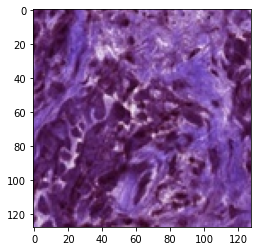

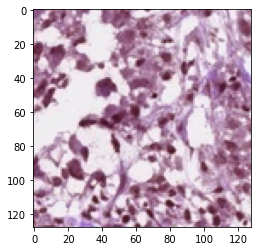

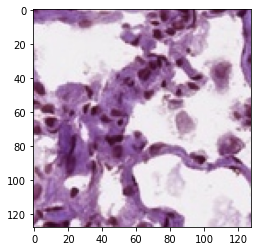

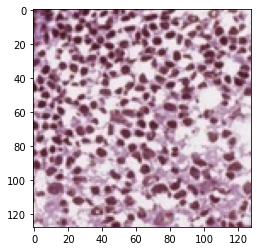

In [14]:
ShowImg(artifacts_imgs[0])
ShowImg(cancer_imgs[0])
ShowImg(normal_imgs[0])
ShowImg(other_imgs[0])

In [174]:
x_test = torch.cat((artifacts_imgs[0:100], cancer_imgs[0:100], normal_imgs[0:100], other_imgs[0:100]), 0)
x_test.shape

torch.Size([400, 3, 128, 128])

In [175]:
y_test = 400*[0]
for i in range(0,400):
    if 0<=i<100:
        y_test[i]=0
    elif 100<=i<200:
        y_test[i]=1
    elif 200<=i<300:
        y_test[i]=2
    else:
        y_test[i]=3
y_test = torch.tensor(y_test)
y_test.size()

torch.Size([400])

In [176]:
x_train = torch.cat((artifacts_imgs[100:], cancer_imgs[100:], normal_imgs[100:], other_imgs[100:]), 0)
x_train.shape

torch.Size([6529, 3, 128, 128])

In [177]:
y_train=np.full((1,len(artifacts_imgs[100:])),0)
y_train=np.append(y_train,np.full((1,len(cancer_imgs[100:])),1))
y_train=np.append(y_train,np.full((1,len(normal_imgs[100:])),2))
y_train=np.append(y_train,np.full((1,len(other_imgs[100:])),3))
y_train = torch.tensor(y_train)
y_train.size()

torch.Size([6529])

In [178]:
x_train = x_train/255
x_test = x_test/255

In [179]:
x_train,x_val, y_train, y_val= train_test_split(x_train,y_train,test_size=0.2, shuffle=True, stratify=y_train)

In [21]:
class cnn(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn_layers = torch.nn.Sequential(
            
            # Defining a 2D convolution layer
            torch.nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Defining another 2D convolution layer
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
    
        self.linear_layers = torch.nn.Sequential(
            torch.nn.Flatten(1),
            torch.nn.Linear(256 * 2 *2, 512),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(512, 4)
        )
    
    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [23]:
net = cnn().to(device)
print(net)

cnn(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=512, bias

In [24]:
import torch.optim as optim
loss_func = torch.nn.CrossEntropyLoss()
lr = 0.001
weight_decay=0.01
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay)
optimizer_name = 'Adam'

In [17]:
import torch.utils.data as Data

In [188]:
torch_dataset = Data.TensorDataset(x_train,y_train)
loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4
)

In [192]:
torch_val = Data.TensorDataset(x_val,y_val)
loader_val = Data.DataLoader(
    dataset=torch_val,
    batch_size=128,
    shuffle=True,
    num_workers=4
)

In [198]:
train_lost = []
train_index = []
val_loss = []
val_accuracy = []
best_val_acc = 0
patience = 0
PATH = 'models/base_'+'batchsize'+str(batch_size)+'_'+optimizer_name+'_lr'+str(lr)+'_weightDecay'+str(weight_decay)+'.pth'
batch_size =128

for epoch in range(40):
    train_running_loss = 0.0
    for step,(batch_x,batch_y) in enumerate(loader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        prediction = net(batch_x)
        loss = loss_func(prediction, batch_y)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()
    
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader_val:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            
    cur_val_acc = correct / total
    if cur_val_acc > best_val_acc:
        best_val_acc = cur_val_acc
        torch.save(net.state_dict(), "/Users/lyh1314qwe/Desktop/SBS Course/BS6207/Assignment4/工作簿1.csv")
        patience = 0
    else:
        patience+=1
        
    if patience == 40:
        print('Model is overfit!')
        break
        
    print('epoch' + str(epoch) + ' train loss: ' + str(train_running_loss/len(loader))+', val loss: '
          +str(val_running_loss/len(loader_val))+' val accuracy: '
          + str(correct / total)+', '+'patience: '+str(patience))

    train_lost.append(train_running_loss/len(loader))
    val_loss.append(val_running_loss/len(loader_val))
    val_accuracy.append(correct / total)

epoch0 train loss: 0.13003402621280857, val loss: 0.15147478878498077 val accuracy: 0.9433384379785605, patience: 0
epoch1 train loss: 0.11059572206946408, val loss: 0.1457458422942595 val accuracy: 0.9418070444104135, patience: 1
epoch2 train loss: 0.12024299655018783, val loss: 0.14758349616419186 val accuracy: 0.942572741194487, patience: 2
epoch3 train loss: 0.0953578155760358, val loss: 0.16209670223973013 val accuracy: 0.9494640122511485, patience: 0
epoch4 train loss: 0.12130894929897494, val loss: 0.2388692315329205 val accuracy: 0.9326186830015314, patience: 1
epoch5 train loss: 0.10503230807257861, val loss: 0.1757908747954802 val accuracy: 0.947166921898928, patience: 2
epoch6 train loss: 0.09976871511558207, val loss: 0.1662780845707113 val accuracy: 0.9418070444104135, patience: 3
epoch7 train loss: 0.07249298469140762, val loss: 0.14441461962732402 val accuracy: 0.9448698315467075, patience: 4
epoch8 train loss: 0.08901015564617587, val loss: 0.17206342111934314 val accur

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def PrintReport(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names=['Artifactes','Cancer Regions','Normal Regions','Others'] ))
    sns.heatmap(cm, annot=True,fmt='g',cmap ='Reds',xticklabels=['Artifactes','Cancer Regions','Normal Regions','Others'],yticklabels=['Artifactes','Cancer Regions','Normal Regions','Others'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

def Predict(net,X):
    test_pred = net(X)
    res =test_pred.data
    y_pred=torch.max(res,1)[1]
    return y_pred

                precision    recall  f1-score   support

    Artifactes       0.91      0.98      0.94       100
Cancer Regions       0.71      1.00      0.83       100
Normal Regions       0.92      0.87      0.89       100
        Others       1.00      0.56      0.72       100

      accuracy                           0.85       400
     macro avg       0.88      0.85      0.85       400
  weighted avg       0.88      0.85      0.85       400



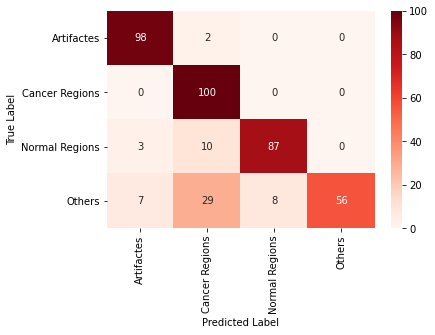

In [200]:
y_pred=Predict(net,x_test)
PrintReport(y_test,y_pred)

In [ ]:
train_lost, val_loss, val_accuracy, 

In [203]:
index = []
for i in range(40):
    index.append(i)
index

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39]

In [206]:
df = pd.DataFrame(index = np.arange(len(train_lost)))
df["train_loss"] = train_lost
df["val_loss"] = val_loss

[Text(0, 0.5, 'loss'), Text(0.5, 0, 'epoch'), Text(0.5, 1.0, 'epoch vs loss')]

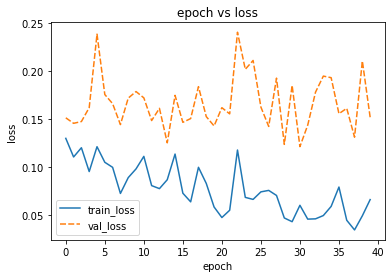

In [208]:
sns.lineplot(data = df).set(title = 'epoch vs loss', xlabel = 'epoch', ylabel='loss')

[Text(0, 0.5, 'accuracy'),
 Text(0.5, 0, 'epoch'),
 Text(0.5, 1.0, 'epoch vs val_accuracy')]

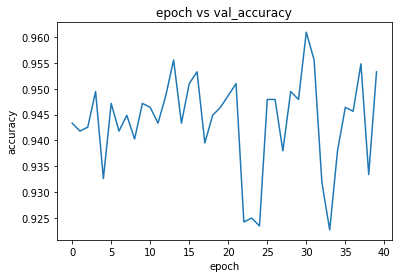

In [210]:
sns.lineplot(index,val_accuracy).set(title = 'epoch vs val_accuracy', xlabel = 'epoch', ylabel='accuracy')

In [ ]:
# from keras.datasets import mnist
# from keras.utils import to_categorical
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

# img_rows, img_cols = 128, 128
# num_classes = 4
# batch_size = 64
# epochs = 41

# # x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
# # x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
# # x_train = x_train/255
# # x_test  = x_test/255
# # y_train = to_categorical(y_train, num_classes)
# # y_test = to_categorical(y_test, num_classes)

In [43]:
# model = Sequential()

# model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',strides=(2, 2),
#     padding=1, input_shape=(img_rows, img_cols, 3)))

# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))
# model.compile(loss='categorical_crossentropy',
#       optimizer='adam',
#       metrics=['accuracy'])

In [ ]:
PATH = pd.read_csv("/Users/lyh1314qwe/Desktop/SBS Course/BS6207/Assignment4/工作簿1.csv")

In [ ]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH))
net.eval()

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        #print(labels, outputs, predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: '+ str(100 * correct / total))

In [19]:
x_train_40 = torch.cat((artifacts_imgs[100:113], cancer_imgs[100:117], normal_imgs[100:107], other_imgs[100:103]), 0)
y_train_40=np.full((1,len(artifacts_imgs[100:113])),0)
y_train_40=np.append(y_train_40,np.full((1,len(cancer_imgs[100:117])),1))
y_train_40=np.append(y_train_40,np.full((1,len(normal_imgs[100:107])),2))
y_train_40=np.append(y_train_40,np.full((1,len(other_imgs[100:103])),3))
y_train_40 = torch.tensor(y_train_40)
x_train_40 = x_train_40/255
x_train,x_val, y_train, y_val= train_test_split(x_train_40,y_train_40,test_size=0.2, shuffle=True, stratify=y_train_40)
torch_dataset = Data.TensorDataset(x_train,y_train)
loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=10,
    shuffle=True,
    num_workers=4
)

In [20]:
x_test = torch.cat((artifacts_imgs[0:3], cancer_imgs[0:4], normal_imgs[0:1], other_imgs[0:2]), 0)

y_test = 10*[0]
for i in range(0,10):
    if 0<=i<3:
        y_test[i]=0
    elif 3<=i<7:
        y_test[i]=1
    elif 7<=i<9:
        y_test[i]=2
    else:
        y_test[i]=3
y_test = torch.tensor(y_test)
y_test.size()

torch_val = Data.TensorDataset(x_val,y_val)
loader_val = Data.DataLoader(
    dataset=torch_val,
    batch_size=5,
    shuffle=True,
    num_workers=4
)

In [28]:
batch_size =10
train_lost = []
train_index = []
val_loss = []
val_accuracy = []
best_val_acc = 0
patience = 0
PATH = 'models/base_'+'batchsize'+str(batch_size)+'_'+optimizer_name+'_lr'+str(lr)+'_weightDecay'+str(weight_decay)+'.pth'


for epoch in range(40):
    train_running_loss = 0.0
    for step,(batch_x,batch_y) in enumerate(loader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        prediction = net(batch_x)
        loss = loss_func(prediction, batch_y)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()
    
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader_val:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = loss_func(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            
    cur_val_acc = correct / total
    if cur_val_acc > best_val_acc:
        best_val_acc = cur_val_acc
        torch.save(net.state_dict(), "/Users/lyh1314qwe/Desktop/SBS Course/BS6207/Assignment4/工作簿1.csv")
        patience = 0
    else:
        patience+=1
        
    if patience == 40:
        print('Model is overfit!')
        break
        
    print('epoch' + str(epoch) + ' train loss: ' + str(train_running_loss/len(loader))+', val loss: '
          +str(val_running_loss/len(loader_val))+' val accuracy: '
          + str(correct / total)+', '+'patience: '+str(patience))

    train_lost.append(train_running_loss/len(loader))
    val_loss.append(val_running_loss/len(loader_val))
    val_accuracy.append(correct / total)

epoch0 train loss: 0.4328402439132333, val loss: 0.6263439953327179 val accuracy: 0.75, patience: 0
epoch1 train loss: 0.771633680909872, val loss: 1.1668699979782104 val accuracy: 0.5, patience: 1
epoch2 train loss: 0.440587542951107, val loss: 1.629025936126709 val accuracy: 0.375, patience: 2
epoch3 train loss: 0.47885591350495815, val loss: 0.7075876779854298 val accuracy: 0.75, patience: 3
epoch4 train loss: 0.3261834802106023, val loss: 1.2028546035289764 val accuracy: 0.5, patience: 4
epoch5 train loss: 0.32717411033809185, val loss: 0.5901476293802261 val accuracy: 0.875, patience: 0
epoch6 train loss: 0.1480148248374462, val loss: 0.5758362114429474 val accuracy: 0.75, patience: 1
epoch7 train loss: 0.5141215929761529, val loss: 0.47564058005809784 val accuracy: 0.75, patience: 2
epoch8 train loss: 0.3654487100429833, val loss: 2.785524606704712 val accuracy: 0.625, patience: 3
epoch9 train loss: 1.7890297044068575, val loss: 0.990702211856842 val accuracy: 0.75, patience: 4
e

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

    Artifactes       1.00      1.00      1.00         3
Cancer Regions       0.75      0.75      0.75         4
Normal Regions       0.33      0.50      0.40         2
        Others       0.00      0.00      0.00         1

      accuracy                           0.70        10
     macro avg       0.52      0.56      0.54        10
  weighted avg       0.67      0.70      0.68        10



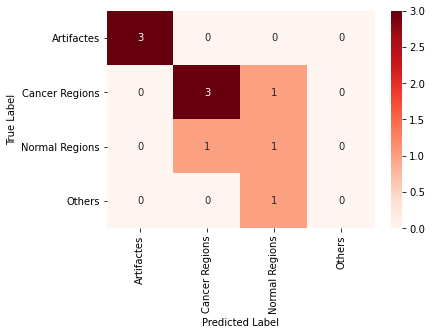

In [30]:
y_pred=Predict(net,x_test)
PrintReport(y_test,y_pred)

In [1]:
x_train_40 = torch.cat((artifacts_imgs[100:230], cancer_imgs[100:270], normal_imgs[100:170], other_imgs[100:130]), 0)
y_train_40=np.full((1,len(artifacts_imgs[100:230])),0)
y_train_40=np.append(y_train_40,np.full((1,len(cancer_imgs[100:270])),1))
y_train_40=np.append(y_train_40,np.full((1,len(normal_imgs[100:170])),2))
y_train_40=np.append(y_train_40,np.full((1,len(other_imgs[100:130])),3))
y_train_40 = torch.tensor(y_train_40)
x_train_40 = x_train_40/255
x_train,x_val, y_train, y_val= train_test_split(x_train_40,y_train_40,test_size=0.2, shuffle=True, stratify=y_train_40)
torch_dataset = Data.TensorDataset(x_train,y_train)
loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=10,
    shuffle=True,
    num_workers=4
)

x_test = torch.cat((artifacts_imgs[0:15], cancer_imgs[0:20], normal_imgs[0:10], other_imgs[0:5]), 0)

y_test = 10*[0]
for i in range(0,10):
    if 0<=i<3:
        y_test[i]=0
    elif 3<=i<7:
        y_test[i]=1
    elif 7<=i<9:
        y_test[i]=2
    else:
        y_test[i]=3
y_test = torch.tensor(y_test)
y_test.size()

torch_val = Data.TensorDataset(x_val,y_val)
loader_val = Data.DataLoader(
    dataset=torch_val,
    batch_size=5,
    shuffle=True,
    num_workers=4
)

batch_size =10
train_lost = []
train_index = []
val_loss = []
val_accuracy = []
best_val_acc = 0
patience = 0
PATH = 'models/base_'+'batchsize'+str(batch_size)+'_'+optimizer_name+'_lr'+str(lr)+'_weightDecay'+str(weight_decay)+'.pth'


for epoch in range(40):
    train_running_loss = 0.0
    for step,(batch_x,batch_y) in enumerate(loader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        prediction = net(batch_x)
        loss = loss_func(prediction, batch_y)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()
    
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader_val:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = loss_func(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            
    cur_val_acc = correct / total
    if cur_val_acc > best_val_acc:
        best_val_acc = cur_val_acc
        torch.save(net.state_dict(), "/Users/lyh1314qwe/Desktop/SBS Course/BS6207/Assignment4/工作簿1.csv")
        patience = 0
    else:
        patience+=1
        
    if patience == 40:
        print('Model is overfit!')
        break
        
    print('epoch' + str(epoch) + ' train loss: ' + str(train_running_loss/len(loader))+', val loss: '
          +str(val_running_loss/len(loader_val))+' val accuracy: '
          + str(correct / total)+', '+'patience: '+str(patience))

    train_lost.append(train_running_loss/len(loader))
    val_loss.append(val_running_loss/len(loader_val))
    val_accuracy.append(correct / total)

In [ ]:
x_train_40 = torch.cat((artifacts_imgs[100:230], cancer_imgs[100:270], normal_imgs[100:170], other_imgs[100:130]), 0)
y_train_40=np.full((1,len(artifacts_imgs[100:230])),0)
y_train_40=np.append(y_train_40,np.full((1,len(cancer_imgs[100:270])),1))
y_train_40=np.append(y_train_40,np.full((1,len(normal_imgs[100:170])),2))
y_train_40=np.append(y_train_40,np.full((1,len(other_imgs[100:130])),3))
y_train_40 = torch.tensor(y_train_40)
x_train_40 = x_train_40/255
x_train,x_val, y_train, y_val= train_test_split(x_train_40,y_train_40,test_size=0.2, shuffle=True, stratify=y_train_40)
torch_dataset = Data.TensorDataset(x_train,y_train)
loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=10,
    shuffle=True,
    num_workers=4
)

x_test = torch.cat((artifacts_imgs[0:15], cancer_imgs[0:20], normal_imgs[0:10], other_imgs[0:5]), 0)

y_test = 10*[0]
for i in range(0,10):
    if 0<=i<3:
        y_test[i]=0
    elif 3<=i<7:
        y_test[i]=1
    elif 7<=i<9:
        y_test[i]=2
    else:
        y_test[i]=3
y_test = torch.tensor(y_test)
y_test.size()

torch_val = Data.TensorDataset(x_val,y_val)
loader_val = Data.DataLoader(
    dataset=torch_val,
    batch_size=5,
    shuffle=True,
    num_workers=4
)

batch_size =10
train_lost = []
train_index = []
val_loss = []
val_accuracy = []
best_val_acc = 0
patience = 0
PATH = 'models/base_'+'batchsize'+str(batch_size)+'_'+optimizer_name+'_lr'+str(lr)+'_weightDecay'+str(weight_decay)+'.pth'


for epoch in range(40):
    train_running_loss = 0.0
    for step,(batch_x,batch_y) in enumerate(loader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        prediction = net(batch_x)
        loss = loss_func(prediction, batch_y)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()
    
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader_val:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = loss_func(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            
    cur_val_acc = correct / total
    if cur_val_acc > best_val_acc:
        best_val_acc = cur_val_acc
        torch.save(net.state_dict(), "/Users/lyh1314qwe/Desktop/SBS Course/BS6207/Assignment4/工作簿1.csv")
        patience = 0
    else:
        patience+=1
        
    if patience == 40:
        print('Model is overfit!')
        break
        
    print('epoch' + str(epoch) + ' train loss: ' + str(train_running_loss/len(loader))+', val loss: '
          +str(val_running_loss/len(loader_val))+' val accuracy: '
          + str(correct / total)+', '+'patience: '+str(patience))

    train_lost.append(train_running_loss/len(loader))
    val_loss.append(val_running_loss/len(loader_val))
    val_accuracy.append(correct / total)